In [1]:
!pip install tonic


In [2]:
!pip install snntorch


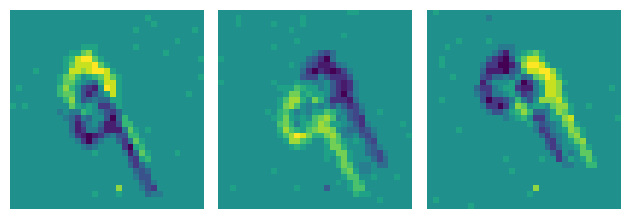

In [ ]:

import tonic

nmnist = tonic.datasets.NMNIST("../tutorials/data", train=False)
events, label = nmnist[0]

tonic.utils.plot_event_grid(events)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_frames(frames):
    fig, axes = plt.subplots(1, len(frames))
    for axis, frame in zip(axes, frames):
        axis.imshow(frame[1] - frame[0])
        axis.axis("off")
    plt.tight_layout()


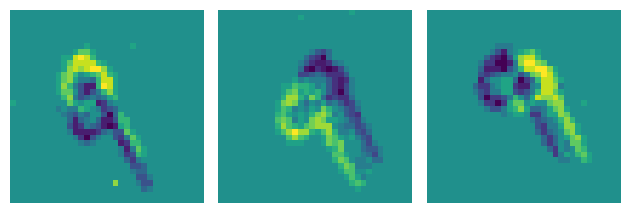

In [ ]:
sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, n_time_bins=3)
denoise_transform = tonic.transforms.Denoise(filter_time=10000)

events_denoised = denoise_transform(events)
frames_denoised = frame_transform(events_denoised)

plot_frames(frames_denoised)


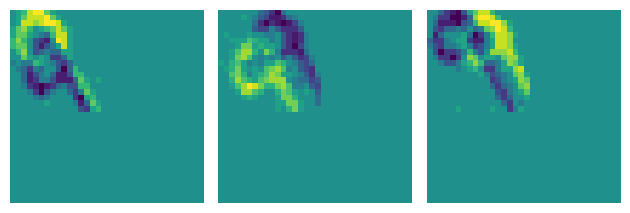

In [ ]:
cropped_size = (18, 18)

sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, n_time_bins=3)
crop_transform = tonic.transforms.CenterCrop(sensor_size = sensor_size, size=cropped_size)

events_cropped = crop_transform(events)
frames_cropped = frame_transform(events_cropped)

plot_frames(frames_cropped)


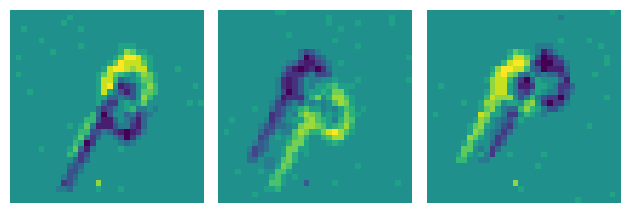

In [ ]:
cropped_size = (18, 18)

sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, n_time_bins=3)
flip_transform = tonic.transforms.RandomFlipLR(sensor_size=sensor_size, p=1)

events_flipped = flip_transform(events)
frames_flipped = frame_transform(events_flipped)

plot_frames(frames_flipped)


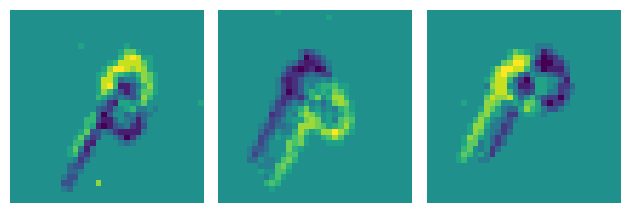

In [ ]:
import tonic.transforms as transforms

cropped_size = (18, 18)

sensor_size = tonic.datasets.NMNIST.sensor_size

frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size , n_time_bins=3)
                                     ])
flip_transform = tonic.transforms.RandomFlipLR(sensor_size=sensor_size, p=1)

events_flipped = flip_transform(events)
frames_flipped = frame_transform(events_flipped)

plot_frames(frames_flipped)


In [ ]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)

In [ ]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset


cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 32
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())


In [ ]:
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      ])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 32
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))


In [ ]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
g_transform = torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
r_transform = torchvision.transforms.RandomRotation(degrees=(30, 45))

In [ ]:
train_features, train_labels  = next(iter(trainloader))
train_features.shape

torch.Size([310, 64, 2, 34, 34])

In [ ]:
img = train_features[0]
g_transform(img).shape


torch.Size([64, 2, 34, 34])

In [ ]:
# neuron and simulation parameters
#spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.9
num_steps = 5

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float


In [ ]:
# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)


In [ ]:
net.parameters

<bound method Module.parameters of Sequential(
  (0): Conv2d(2, 12, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Leaky()
  (3): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Leaky()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=800, out_features=16, bias=True)
  (8): Leaky()
)>

In [ ]:
# this time, we won't return membrane as we don't need it

def forward_pass(net, data , transformation):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  

  for step in range(data.size(0)): 
      spk_out, mem_out = net(transformation(data[step]))# data.size(0) = number of time steps
      spk_rec.append(spk_out)
      
  return torch.stack(spk_rec)

In [ ]:
g_transform = torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
r_transform = torchvision.transforms.RandomRotation(degrees=(30, 45))

data, targets = next(iter(trainloader))
data = data.to(device)
targets = targets.to(device)

net.train()
spk_rec = forward_pass(net, data , g_transform)
spk_rec.shape

torch.Size([311, 64, 16])

In [ ]:
data.shape

torch.Size([309, 32, 2, 34, 34])

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))


In [ ]:
! pip install pytorch-metric-learning


In [ ]:
from pytorch_metric_learning.losses import NTXentLoss
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer
from pytorch_metric_learning import losses
from pytorch_metric_learning.losses import SelfSupervisedLoss

In [ ]:
#loss

loss_func_self_trip = SelfSupervisedLoss(losses.TripletMarginLoss(distance = CosineSimilarity(), 
                                    reducer = ThresholdReducer(high=0.3), 
                                    embedding_regularizer = LpRegularizer()))
loss_func_NTX = NTXentLoss()
loss_func_triplet = losses.TripletMarginLoss(distance = CosineSimilarity(), 
                                    reducer = ThresholdReducer(high=0.3), 
                                    embedding_regularizer = LpRegularizer())

loss_func_self_con = SelfSupervisedLoss(losses.ContrastiveLoss(pos_margin=0, neg_margin=1))

In [ ]:
num_epochs = 1
num_iters = 100

loss_hist = []
acc_hist = []
i=0
g_transform = torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
r_transform = torchvision.transforms.RandomRotation(degrees=(30, 45))

# training loop
for epoch in range(num_epochs):
    for i , (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()

        spk_rec_r = forward_pass(net, data , r_transform)
        spk_rec_g = forward_pass(net, data , g_transform)

        loss_val = torch.zeros((1), dtype=dtype, device=device)

        for step in range(spk_rec_r.size(0)): 
          loss_val += loss_func_self_con(spk_rec_r[step], spk_rec_g[step])

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        #print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        #acc = SF.accuracy_rate(spk_rec, targets)
        #acc_hist.append(acc)
        #print(f"Accuracy: {acc * 100:.2f}%\n")

        # training loop breaks after 50 iterations
        if i == num_iters:
          break

0
100


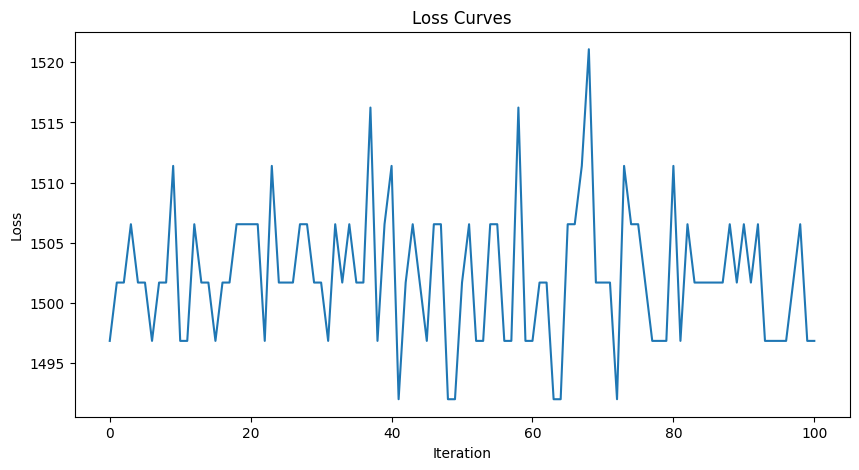

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.title("Loss Curves")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()